<a href="https://colab.research.google.com/github/idebroy/ml-ds/blob/main/offline_fail.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive

In [ ]:
# prompt: write a function to load a csv file from google drive
def load_csv_from_drive(file_path):
  """Loads a CSV file from Google Drive into a pandas DataFrame.

  Args:
    file_path: The path to the CSV file on Google Drive.

  Returns:
    A pandas DataFrame containing the data from the CSV file.
  """
  drive.mount('/content/drive', force_remount=True)

  try:
    df = pd.read_csv(file_path)
    return df
  except FileNotFoundError:
    print(f"Error: File not found at {file_path}")
    return None
  except Exception as e:
    print(f"An error occurred while loading the file: {e}")
    return None

# Example usage:
# Assuming your CSV file is located at '/content/drive/My Drive/my_data.csv'
testFilePath = '/content/drive/My Drive/Colab-Stuff/offline-fail.csv'
df = load_csv_from_drive(testFilePath)
print(f"Drive \"connected to:\" {testFilePath}")

# If the file is loaded successfully, you can work with the DataFrame 'df'.
# For example, you can print the first few rows:
print(df.head())

Mounted at /content/drive
Drive "connected to:" /content/drive/My Drive/Colab-Stuff/offline-fail.csv
           id           uuid  order_id  customer_id  customer_uuid  \
0  3920481938  8SYQXGQZAX75P    994395          NaN            NaN   
1  3920481963  SY8ZX7YNZ82P4    994433          NaN            NaN   
2  3920482443  C26H3KW534N2E    994971          NaN            NaN   
3  3920492858  ASJF540XTPASP   1026537          NaN            NaN   
4  3920493555  HPMGXNTE97NCM   1027587          NaN            NaN   

   merchant_id  merchant_tender_id  amount  tip_amount  tax_amount  ...  \
0        14005              113167      55         NaN          10  ...   
1        14005              113167    2170         NaN         395  ...   
2        14005              113167    1136         NaN         207  ...   
3         8277               66813    1100         0.0         100  ...   
4        12617              101703     452         NaN           0  ...   

   payment_refund_id  exter

In [ ]:
def impute_categorical_nan(data, column):
  """
  Imputes missing values in a categorical column with the most frequent value.

  Args:
    data: Pandas DataFrame.
    column: Name of the categorical column with missing values.

  Returns:
    Pandas DataFrame with imputed values.
  """

  # Find the most frequent value
  most_frequent_value = data[column].mode()[0]
  print(most_frequent_value)

  # Fill missing values with the most frequent value
  data[column] = data[column].fillna(most_frequent_value)

  return data

def impute_numerical_nan(data, column):
  """
  Imputes missing values in a numerical column with the mean.
  Args:
    data: Pandas DataFrame.
    column: Name of the numerical column with missing values.
  Returns:
    Pandas DataFrame with imputed values.
  """
  # Calculate the mean
  mean = data[column].mean()

  # Fill missing values with the mean
  data[column] = data[column].fillna(mean)

  return data

def impute_nan(data, column):
  """
  Imputes missing values in a column based on its data type.

  Args:
    data: Pandas DataFrame.
    column: Name of the column with missing values.

  Returns:
    Pandas DataFrame with imputed values.
  """
  if column in data.select_dtypes(include=['number']).columns:
    data = impute_numerical_nan(data, column)
  else:
    data = impute_categorical_nan(data, column)

  return data

def find_cat_correlation(data, cat_cols, target_col):
  """
  Finds the categorical column most highly correlated (using Cramér's V) with the target column.

  Args:
      data: Pandas DataFrame.
      cat_cols: List of categorical columns.
      target_col: Name of the target column (must be categorical).

  Returns:
      Name of the most highly correlated categorical column.
  """
  from scipy.stats import chi2_contingency

  correlations = {}

  for col in cat_cols:
    if col != target_col:
      contingency_table = data.pivot_table(index=target_col, columns=col, aggfunc='size', fill_value=0)
      chi2, _, _, _ = chi2_contingency(contingency_table)
      n = contingency_table.sum().sum()
      phi2 = chi2 / n
      min_dim = min(contingency_table.shape) - 1
      cramers_v = np.sqrt(phi2 / min_dim)
      correlations[col] = cramers_v

  most_correlated_column = max(correlations, key=correlations.get)
  return most_correlated_column

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1975 entries, 0 to 1974
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   1975 non-null   int64  
 1   uuid                 1975 non-null   object 
 2   order_id             1975 non-null   int64  
 3   customer_id          0 non-null      float64
 4   customer_uuid        0 non-null      float64
 5   merchant_id          1975 non-null   int64  
 6   merchant_tender_id   1975 non-null   int64  
 7   amount               1975 non-null   int64  
 8   tip_amount           1428 non-null   float64
 9   tax_amount           1975 non-null   int64  
 10  cashback_amount      1585 non-null   float64
 11  cash_tendered        0 non-null      float64
 12  gateway_tx_id        1975 non-null   int64  
 13  tip_gateway_tx_id    2 non-null      float64
 14  payment_refund_id    0 non-null      float64
 15  external_payment_id  120 non-null    o

In [ ]:
df.describe()

,id,order_id,customer_id,customer_uuid,merchant_id,merchant_tender_id,amount,tip_amount,tax_amount,cashback_amount,cash_tendered,gateway_tx_id,tip_gateway_tx_id,payment_refund_id,account_id,device_id,offline
count,1.975000e+03,1.975000e+03,0.0,0.0,1975.000000,1.975000e+03,1.975000e+03,1428.000000,1975.000000,1585.000000,0.0,1.975000e+03,2.000000,0.0,1973.000000,1567.000000,1975.0
mean,3.921985e+09,2.805097e+11,NaN,NaN,66723.416203,6.134665e+05,5.304333e+03,364.148459,235.292658,24.794953,NaN,1.580348e+06,889473.000000,NaN,142880.687785,96150.305041,1.0
std,2.816459e+06,6.946781e+11,NaN,NaN,79069.348411,7.727714e+05,3.341250e+04,3394.870979,6590.720019,191.609936,NaN,1.616522e+06,8.485281,NaN,135833.606474,41489.237251,0.0
min,3.920482e+09,9.943950e+05,NaN,NaN,554.000000,4.592000e+03,0.000000e+00,0.000000,0.000000,0.000000,NaN,4.041320e+05,889467.000000,NaN,295.000000,8031.000000,1.0
25%,3.920712e+09,1.333242e+06,NaN,NaN,1272.000000,1.043200e+04,3.800000e+02,0.000000,0.000000,0.000000,NaN,5.714135e+05,889470.000000,NaN,31942.000000,56151.000000,1.0
50%,3.920904e+09,1.657475e+06,NaN,NaN,30116.000000,2.420840e+05,9.280000e+02,0.000000,0.000000,0.000000,NaN,7.690770e+05,889473.000000,NaN,55813.000000,87533.000000,1.0
75%,3.921827e+09,3.191576e+06,NaN,NaN,123285.000000,9.941090e+05,2.700000e+03,0.000000,5.000000,0.000000,NaN,1.762348e+06,889476.000000,NaN,265889.000000,139241.000000,1.0
max,3.932715e+09,2.000021e+12,NaN,NaN,243892.000000,2.740998e+06,1.410570e+06,111950.000000,291070.000000,4000.000000,NaN,6.418188e+06,889479.000000,NaN,633823.000000,168224.000000,1.0


## Compute missing values

In [ ]:
# Calculate the number of missing values in each column
missing_values_count = df.isnull().sum()

# Display the missing values count
print("Missing values per column:")
print(missing_values_count)

Missing values per column:
id                        0
uuid                      0
order_id                  0
customer_id            1975
customer_uuid          1975
merchant_id               0
merchant_tender_id        0
amount                    0
tip_amount              547
tax_amount                0
cashback_amount         390
cash_tendered          1975
gateway_tx_id             0
tip_gateway_tx_id      1973
payment_refund_id      1975
external_payment_id    1855
account_id                2
device_id               408
note                   1805
created_time              0
client_created_time       0
modified_time             0
offline                   0
result                    0
dtype: int64


In [ ]:
# Identify columns with more than 500 missing values
columns_to_drop = missing_values_count[missing_values_count > 500].index.tolist()

# Filter columns_to_drop to only include those present in the current DataFrame
existing_columns_to_drop = [col for col in columns_to_drop if col in df.columns]

# Drop the identified columns that exist in the DataFrame
df = df.drop(columns=existing_columns_to_drop)

# Display the updated DataFrame info to confirm the columns are dropped
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1975 entries, 0 to 1974
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   1975 non-null   int64  
 1   uuid                 1975 non-null   object 
 2   order_id             1975 non-null   int64  
 3   merchant_id          1975 non-null   int64  
 4   merchant_tender_id   1975 non-null   int64  
 5   amount               1975 non-null   int64  
 6   tax_amount           1975 non-null   int64  
 7   cashback_amount      1585 non-null   float64
 8   gateway_tx_id        1975 non-null   int64  
 9   account_id           1973 non-null   float64
 10  device_id            1567 non-null   float64
 11  created_time         1975 non-null   object 
 12  client_created_time  1975 non-null   object 
 13  modified_time        1975 non-null   object 
 14  offline              1975 non-null   int64  
 15  result               1975 non-null   o

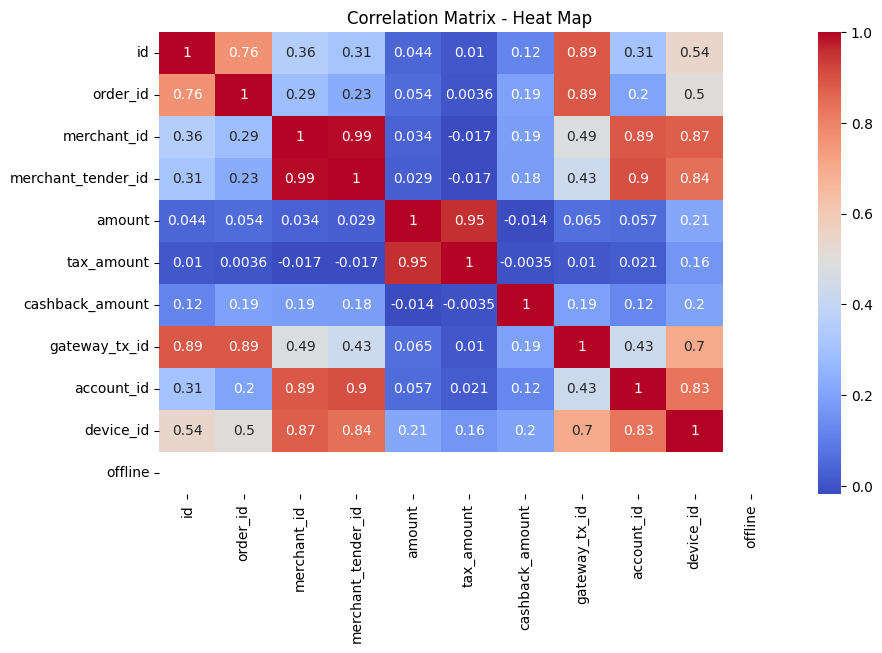

In [ ]:
# Correlation matrix - Heat Map
plt.figure(figsize=(10, 6))

# Select only numerical columns for correlation matrix
numerical_cols = df.select_dtypes(include=[np.number])
sns.heatmap(numerical_cols.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix - Heat Map')
plt.show()